# Report: Collaboration and Competition with MADDPG

### Project Overview

The goal of this project is to train two reinforcement learning agents to play a game of tennis. The agents control rackets and must learn to hit a ball back and forth over a net. This is a multi-agent environment where the agents can be seen as both collaborating (to keep the rally going) and competing.

The task is solved using a **Multi-Agent Deep Deterministic Policy Gradient (MADDPG)** algorithm, enhanced with techniques from **Twin-Delayed DDPG (TD3)** for improved stability. The environment is considered "solved" when the agents achieve an average score of **+0.5 over 100 consecutive episodes**.

## 1. Learning Algorithm

The algorithm implemented to solve this environment is the **Multi-Agent Deep Deterministic Policy Gradient (MADDPG)**. This is an actor-critic method that extends the DDPG algorithm to multi-agent settings, making it suitable for environments with both cooperative and competitive elements.

### Key Concepts: MADDPG with TD3 Enhancements

1.  **Centralized Training with Decentralized Execution (CTDE)**: This is the core idea behind MADDPG.
    *   **Centralized Training**: During training, a centralized **critic** for each agent has access to the observations and actions of *all* agents. This global perspective allows the critic to learn a stable and accurate Q-function, even though the environment is non-stationary from the perspective of any single agent (since other agents' policies are also changing).
    *   **Decentralized Execution**: During execution (acting in the environment), each agent's **actor** only uses its own local observations to select an action. This is practical for real-world scenarios where agents may not have access to global information.

2.  **Independent Agents**: The implementation consists of two independent DDPG agents, each with its own actor and critic networks. However, they share a common experience replay buffer.

3.  **TD3 Enhancements for Stability**: To improve upon the stability of DDPG, this implementation incorporates key features from the **Twin-Delayed DDPG (TD3)** algorithm:
    *   **Clipped Double-Q Learning**: Two critic networks are used for each agent. When calculating the target Q-value for the Bellman update, the *minimum* of the two critics' predictions is used. This helps to mitigate the overestimation bias commonly found in Q-learning methods.
    *   **Target Policy Smoothing**: Noise is added to the target action during the critic update. This smooths the value function and makes the policy less likely to exploit narrow peaks in the Q-function.
    *   **Delayed Policy Updates**: The actor (policy) and target networks are updated less frequently than the critic networks. This allows the critic's value estimate to stabilize before the policy is updated, leading to more stable training.

### Model Architectures

**Actor Network** (for each agent)
*   **Input Layer**: 24 units (State Size)
*   **Hidden Layer 1**: 256 units (with ReLU activation)
*   **Hidden Layer 2**: 128 units (with ReLU activation)
*   **Output Layer**: 2 units (Action Size, with Tanh activation)

**Critic Network** (for each agent, two critics per agent for TD3)
The critic takes the combined states and actions of *all* agents as input.
*   **Input Layer (States)**: 48 units (24 per agent * 2 agents) -> **Hidden Layer 1**: 256 units (with Leaky ReLU)
*   **Concatenation**: The output is concatenated with the combined action vector (4 units total).
*   **Hidden Layer 2**: 256 units (with Leaky ReLU)
*   **Hidden Layer 3**: 128 units (with Leaky ReLU)
*   **Output Layer**: 1 unit (Q-value)

### Hyperparameters

| Hyperparameter            | Value           | Description                                                        |
| ------------------------- | --------------- | ------------------------------------------------------------------ |
| `BUFFER_SIZE`             | 1e6             | Replay buffer size                                                 |
| `BATCH_SIZE`              | 256             | Minibatch size                                                     |
| `GAMMA`                   | 0.99            | Discount factor                                                    |
| `TAU`                     | 1e-3            | Soft update parameter for target networks                          |
| `LR_ACTOR`                | 1e-4            | Learning rate for the actor optimizer                              |
| `LR_CRITIC`               | 3e-4            | Learning rate for the critic optimizer                             |
| `WEIGHT_DECAY`            | 0               | L2 weight decay                                                    |
| `NOISE_SIGMA`             | 0.2             | Ornstein-Uhlenbeck noise `sigma` parameter                         |
| `UPDATE_EACH`             | 1               | Update the network every 1 time step                               |
| `UPDATES_PER_STEP`        | 1               | Perform 1 update per time step                                     |
| `TD3_DELAY`               | 2               | Delay policy updates by 2 critic updates                           |
| `TARGET_POLICY_NOISE`     | 0.2             | Stddev of noise for target policy smoothing                        |
| `NOISE_CLIP`              | 0.5             | Clip for target policy smoothing noise                             |
| `n_episodes`              | 3200            | Maximum number of training episodes                                |

# Collaboration and Competition

### 0. Prerequisites

Follow environment creation and dependecy installation guidelines from the README.md file

### 1. Start the Environment

In [1]:
%cd ../../

/Users/olehborovyk/Code/drlnd


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch, os

In [3]:
torch.set_num_threads(4)
torch.set_num_interop_threads(1)
os.environ["OMP_NUM_THREADS"] = "4"

In [4]:
path = os.path.join(os.getcwd(), "DeepRL", "MADDPG", "Tennis.app")
env = UnityEnvironment(file_name=path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. MADDPG Training


In [7]:
import random
import time
from tqdm import tqdm
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from DeepRL.MADDPG.maddpg import MADDPG


In [8]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)

agent = MADDPG(
    state_size=24,
    action_size=2,
    n_agents=2,
    random_seed=RANDOM_SEED,

    # replay / batch
    buffer_size=int(1e6),
    batch_size=256,

    # RL
    gamma=0.99,
    tau=1e-3,

    # optim
    lr_actor=1e-4,
    lr_critic=3e-4,
    weight_decay=0,

    noise_mu=0.0,
    noise_theta=0.15,
    noise_sigma=0.2,

    # update cadence
    warmup_steps=1000,
    update_each=1,
    updates_per_step=1,

    # TD3 bits
    td3_critic=True,
    td3_delay=2,
    target_policy_noise=0.2,
    noise_clip=0.5,
)
n_episodes = 4_000
avg_score_over_k_episodes = 100

In [9]:
scores_deque = deque(maxlen=avg_score_over_k_episodes)                       
all_scores = []
all_actions = []
max_score = -1

with tqdm(total=n_episodes) as pbar:
    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  
        agent.reset(progress=episode/n_episodes)
        
        states = env_info.vector_observations   
        episode_scores = np.zeros(num_agents)
        dones = [0, 0]
        while not np.any(dones):
            actions = agent.act(states, add_noise=True)
            actions = np.array(actions)
            all_actions.append(actions)
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones)
            episode_scores += rewards
            states = next_states
            
        episode_scores = [episode_scores.max()]
        scores_deque.extend(list(episode_scores))
        all_scores.extend(list(episode_scores))
        
        avg_score = np.mean(scores_deque)
        
        if episode % avg_score_over_k_episodes == avg_score_over_k_episodes-1:
            print(f"Avg. score over last {avg_score_over_k_episodes} episodes: {avg_score:.3f}")
        pbar.set_postfix({"Ep. score": f"{episode_scores[0]:.3f}"})
        pbar.update(1)
        
        if avg_score >= 0.5 and episode >= avg_score_over_k_episodes:
            if max_score < 0.5:
                print(f"PROBLEM SOLVED! Achieved {avg_score:.4f} score over the last {avg_score_over_k_episodes} episodes")
            if avg_score > max_score:
                max_score = avg_score
                for i, ag in enumerate(agent.agents):
                    torch.save(ag.actor_local.state_dict(), os.path.join(os.getcwd(), 
                                                                         "DeepRL", "MADDPG", "checkpoints", f'checkpoint_actor_{i}.pth'))
                    torch.save(ag.critic_local.state_dict(), os.path.join(os.getcwd(), 
                                                                         "DeepRL", "MADDPG", "checkpoints", f'checkpoint_critic_{i}.pth'))
                    torch.save(ag.td3_critic_local.state_dict(), os.path.join(os.getcwd(), 
                                                                         "DeepRL", "MADDPG", "checkpoints",  f'checkpoint_td3_critic_{i}.pth'))
            if avg_score >= 1.0:
                print(f"Early stop at episode {episode}")
                break

env.close()


  2%|▎         | 100/4000 [00:27<47:55,  1.36it/s, Ep. score=0.000] 

Avg. score over last 100 episodes: 0.006


  5%|▌         | 200/4000 [01:38<38:48,  1.63it/s, Ep. score=0.000]  

Avg. score over last 100 episodes: 0.002


  8%|▊         | 300/4000 [02:38<37:37,  1.64it/s, Ep. score=0.000]

Avg. score over last 100 episodes: 0.000


 10%|█         | 400/4000 [03:40<38:33,  1.56it/s, Ep. score=0.000]

Avg. score over last 100 episodes: 0.000


 12%|█▎        | 500/4000 [04:41<36:42,  1.59it/s, Ep. score=0.000]

Avg. score over last 100 episodes: 0.000


 15%|█▌        | 600/4000 [05:42<33:40,  1.68it/s, Ep. score=0.000]

Avg. score over last 100 episodes: 0.000


 18%|█▊        | 700/4000 [07:05<34:34,  1.59it/s, Ep. score=0.000]  

Avg. score over last 100 episodes: 0.016


 20%|██        | 800/4000 [08:18<53:39,  1.01s/it, Ep. score=0.100]  

Avg. score over last 100 episodes: 0.010


 22%|██▎       | 900/4000 [10:04<1:07:12,  1.30s/it, Ep. score=0.100]

Avg. score over last 100 episodes: 0.048


 25%|██▌       | 1000/4000 [11:45<33:39,  1.49it/s, Ep. score=0.000] 

Avg. score over last 100 episodes: 0.042


 28%|██▊       | 1100/4000 [13:12<48:19,  1.00it/s, Ep. score=0.090]  

Avg. score over last 100 episodes: 0.029


 30%|███       | 1200/4000 [14:29<30:10,  1.55it/s, Ep. score=0.000]  

Avg. score over last 100 episodes: 0.016


 32%|███▎      | 1300/4000 [15:45<48:05,  1.07s/it, Ep. score=0.000]  

Avg. score over last 100 episodes: 0.013


 35%|███▌      | 1400/4000 [17:08<27:44,  1.56it/s, Ep. score=0.000]  

Avg. score over last 100 episodes: 0.022


 38%|███▊      | 1500/4000 [19:26<29:54,  1.39it/s, Ep. score=0.000]  

Avg. score over last 100 episodes: 0.065


 40%|████      | 1600/4000 [21:20<45:14,  1.13s/it, Ep. score=0.000]  

Avg. score over last 100 episodes: 0.060


 42%|████▎     | 1700/4000 [23:29<45:27,  1.19s/it, Ep. score=0.090]  

Avg. score over last 100 episodes: 0.080


 45%|████▌     | 1800/4000 [26:01<1:23:11,  2.27s/it, Ep. score=0.090]

Avg. score over last 100 episodes: 0.092


 48%|████▊     | 1900/4000 [28:44<1:00:34,  1.73s/it, Ep. score=0.090]

Avg. score over last 100 episodes: 0.098


 50%|█████     | 2000/4000 [31:19<45:53,  1.38s/it, Ep. score=0.100]  

Avg. score over last 100 episodes: 0.091


 52%|█████▎    | 2100/4000 [34:27<1:06:55,  2.11s/it, Ep. score=0.100]

Avg. score over last 100 episodes: 0.112


 55%|█████▌    | 2200/4000 [36:58<45:53,  1.53s/it, Ep. score=0.100]  

Avg. score over last 100 episodes: 0.090


 57%|█████▊    | 2300/4000 [39:39<36:43,  1.30s/it, Ep. score=0.100]  

Avg. score over last 100 episodes: 0.098


 60%|██████    | 2400/4000 [42:29<31:41,  1.19s/it, Ep. score=0.100]  

Avg. score over last 100 episodes: 0.110


 62%|██████▎   | 2500/4000 [45:33<49:13,  1.97s/it, Ep. score=0.090]  

Avg. score over last 100 episodes: 0.119


 65%|██████▌   | 2600/4000 [50:52<1:48:50,  4.66s/it, Ep. score=0.400]

Avg. score over last 100 episodes: 0.200


 68%|██████▊   | 2700/4000 [55:44<1:10:17,  3.24s/it, Ep. score=0.200]

Avg. score over last 100 episodes: 0.169


 70%|███████   | 2800/4000 [1:00:31<45:19,  2.27s/it, Ep. score=0.100]  

Avg. score over last 100 episodes: 0.177


 72%|███████▎  | 2900/4000 [1:06:27<1:18:54,  4.30s/it, Ep. score=0.100]

Avg. score over last 100 episodes: 0.217


 75%|███████▌  | 3000/4000 [1:16:05<1:46:01,  6.36s/it, Ep. score=0.100]

Avg. score over last 100 episodes: 0.340


 78%|███████▊  | 3100/4000 [1:28:58<1:47:37,  7.17s/it, Ep. score=0.600]

Avg. score over last 100 episodes: 0.475


 78%|███████▊  | 3137/4000 [1:33:16<2:25:50, 10.14s/it, Ep. score=1.100]

PROBLEM SOLVED! Achieved 0.5034 score over the last 100 episodes


 80%|████████  | 3200/4000 [1:44:26<2:56:03, 13.20s/it, Ep. score=0.600]

Avg. score over last 100 episodes: 0.563


 82%|████████▎ | 3300/4000 [2:08:48<3:23:34, 17.45s/it, Ep. score=1.100]

Avg. score over last 100 episodes: 0.892


 83%|████████▎ | 3326/4000 [2:16:25<27:38,  2.46s/it, Ep. score=2.600]  

Early stop at episode 3325


### 4. Results

The MADDPG agent was successful in solving the environment.

The environment was solved in 3200 episodes, achieving an average score of over +0.5 across 100 consecutive episodes.

The plot above shows the score for each episode, with the orange line representing the 100-episode moving average. The score initially fluctuates but shows a clear upward trend, eventually surpassing the +0.5 target (red dashed line) and remaining there, indicating a stable and successful learning process.

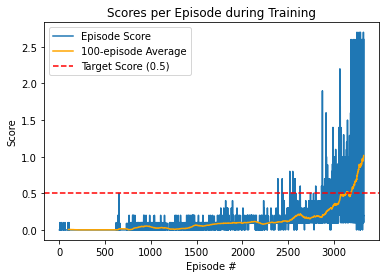

In [10]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(all_scores)+1), all_scores, label='Episode Score')
# Add a 100-episode moving average
rolling_mean = pd.Series(all_scores).rolling(avg_score_over_k_episodes).mean()
plt.plot(rolling_mean, label='100-episode Average', color='orange')
plt.axhline(y=0.5, color='r', linestyle='--', label='Target Score (0.5)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Scores per Episode during Training')
plt.legend()
plt.show()

### 5. Ideas for Future Work

While the MADDPG+TD3 agent performed well, several areas could be explored for further improvement:

1.  **Prioritized Experience Replay (PER)**: Instead of uniform sampling, PER could be used to train more frequently on "surprising" or high-error transitions. This could be adapted for the multi-agent case to improve sample efficiency.

2.  **Alternative Noise Strategies**: The Ornstein-Uhlenbeck process provides temporally correlated noise. It would be interesting to compare its performance with simpler, uncorrelated Gaussian noise or parameter space noise, which sometimes yields better results.

3.  **Hyperparameter Optimization**: A more rigorous search for hyperparameters (e.g., using grid search or Bayesian optimization) could potentially find a configuration that allows the agents to learn even faster or achieve a higher peak performance.

4.  **Exploration of Other Multi-Agent Algorithms**: It would be valuable to implement and compare the performance of other modern multi-agent algorithms, such as **Proximal Policy Optimization for Multi-Agent settings (MA-PPO)**, which is known for its stability.

### 6. Inference

In [1]:
%cd ../../

/Users/olehborovyk/Code/drlnd


In [2]:
# --- NOTE ---
# You may need to restart the kernel and re-run the environment setup cell
# before executing the inference code below.

from unityagents import UnityEnvironment
import torch, os
import numpy as np
from DeepRL.MADDPG.maddpg import MADDPG

# Re-initialize environment
path = os.path.join(os.getcwd(), "DeepRL", "MADDPG", "Tennis.app")
env = UnityEnvironment(file_name=path)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]

# Get environment parameters
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]
num_agents = len(env_info.agents)

# Initialize a new agent
RANDOM_SEED = 4252
np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)

agent = MADDPG(
    state_size=24,
    action_size=2,
    n_agents=2,
    random_seed=RANDOM_SEED,
)

# Load the trained weights
for i, ag in enumerate(agent.agents):
    ag.actor_local.load_state_dict(torch.load(os.path.join(os.getcwd(), "DeepRL", "MADDPG", "checkpoints", f'checkpoint_actor_{i}.pth')))
    ag.critic_local.load_state_dict(torch.load(os.path.join(os.getcwd(), "DeepRL", "MADDPG", "checkpoints", f'checkpoint_critic_{i}.pth')))
    ag.td3_critic_local.load_state_dict(torch.load(os.path.join(os.getcwd(), "DeepRL", "MADDPG", "checkpoints", f'checkpoint_td3_critic_{i}.pth')))

scores = np.zeros(num_agents)
while True:
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    if np.any(dones):
        break

print('Total score this episode: {}'.format(np.max(scores)))

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Total score this episode: 0.0


When finished, you can close the environment.